In [2]:
import os
# os.chdir(r'C:\Users\morel.DESKTOP-PJ169O3\Documents\TravailDeRecherche\Library')
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import copy
from scatcov.frontend import *

/scratch/as356/envs/fac-vae/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate Synthetic Data

Saved: MRW_T_2049_none_H_5_0e_01_la_2_0e_01


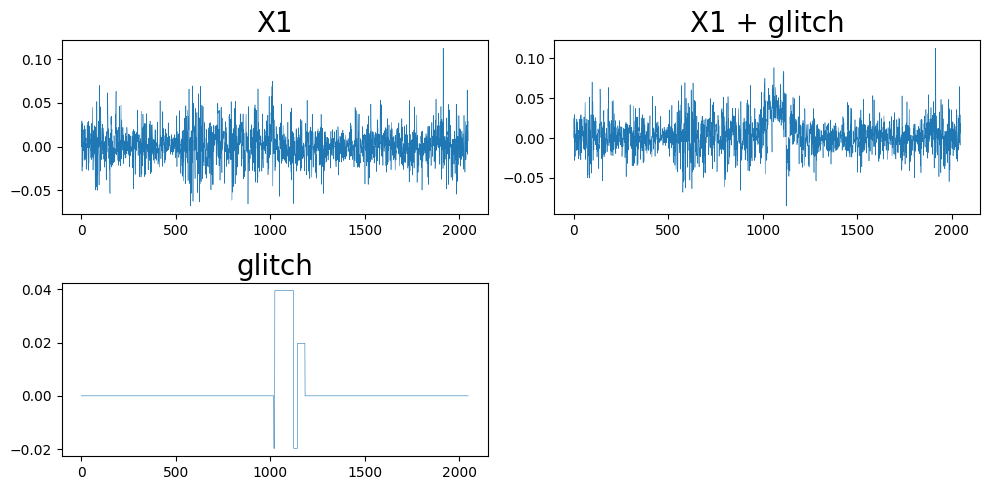

In [3]:
# sum two signals X1 + X2 where X2 is a "glitch"

R = 51

T = 2 ** 11

# X1: background noise signal
dataset = load_data(process_name="mrw", R=R, T=T+1, H=0.5, lam=0.2)[:, 0, :]
dataset = dataset[:, 1:] - dataset[:, :-1]

X1 = copy.copy(dataset[0, :])

# X2: transient localized event, a "glitch"
X2 = np.zeros(T)
X2[T//2-5:T//2] = -1
X2[T//2:T//2+100] = 2
X2[T//2+100:T//2+120] = -1
X2[T//2+120:T//2+160] = 1
X2 /= (X2**2).mean()**0.5
X2 *= 0.5 * np.std(X1)

# plot
plt.figure(figsize=(10,5))
plt.subplot2grid((2,2), (0, 0))
plt.plot(X1, linewidth=0.4)
plt.title('X1', fontsize=20)

plt.subplot2grid((2,2), (1, 0))
plt.plot(X2, linewidth=0.4)
plt.title('glitch', fontsize=20)

plt.subplot2grid((2,2), (0, 1))
plt.plot(X1 + X2, linewidth=0.4)
plt.title('X1 + glitch', fontsize=20)

plt.tight_layout()

# Deglitch through gradient descent

In [4]:
# starting point
x0 = copy.copy(dataset[:R-1, :])
x0[0, :] += X2

# x_deglitched is an candidate for X1
# x_deglitched starts from X1 + X2 and tries to match the statistics of X1
x_deglitched = generate(dataset[1:, :], x0=x0[:,None,:], Q=2,
                        J=7, it=1000, tol_optim=5e-4, cuda=True)[0,0,:]


Data saving dir: gen_scat_cov_battle_lemarie_B50_N1_T2048_J[7, 7]_Q1_2_Q2_2_rmax2_model_cov_tol5_00e_04_it1000
gen_scat_cov: generating data.
Initialize model
Preparing target representation
Embedding: uses 639 coefficients spars=14 mean=1 ps=15 phaseenv=98 envelope=511
     3it in 0:00:00.88 ( 3.42it/s ) .... err 3.68E-02 -- max 8.05E-01 -- maxpct 1553.568% -- gerr 4.69E-04

 -- spars           max 2.79e-01 -- meanpct 3.57% -- maxpct 32.9%, 
 -- mean            max 3.77e-01 -- meanpct 148.37% -- maxpct 692.0%, 
 -- ps              max 8.05e-01 -- meanpct 8.80% -- maxpct 80.5%, 
 -- phaseenv        max 3.30e-01 -- meanpct 113.26% -- maxpct 1553.6%, 
 -- envelope        max 5.35e-01 -- meanpct 7.00% -- maxpct 390.9%, 
     8it in 0:00:01.46 ( 5.48it/s ) .... err 2.22E-02 -- max 2.97E-01 -- maxpct 1173.786% -- gerr 7.48E-05

 -- spars           max 1.36e-01 -- meanpct 2.71% -- maxpct 16.6%, 
 -- mean            max 1.85e-01 -- meanpct 96.83% -- maxpct 339.1%, 
 -- ps              max 2.9

/tmp/ipykernel_30974/3704444260.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((2, 3), (1, 1))


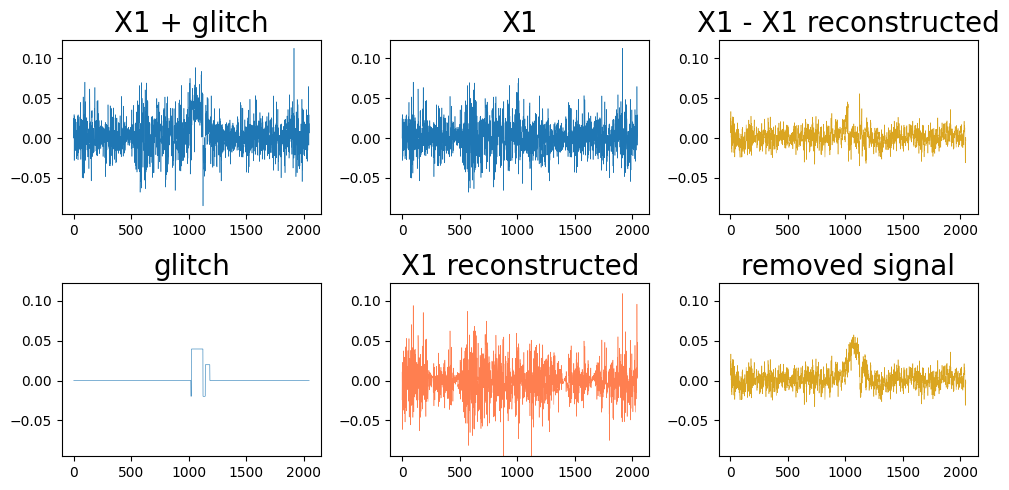

In [6]:
# ploting
plt.figure(figsize=(10,5))

ax = plt.subplot2grid((2, 3), (0, 0))
plt.plot(X1 + X2, linewidth=0.4)
plt.title('X1 + glitch', fontsize=20)
lim = ax.get_ylim()

plt.subplot2grid((2, 3), (1, 0))
plt.plot(X2, linewidth=0.4)
plt.title('glitch', fontsize=20)
plt.ylim(lim)

plt.subplot2grid((2, 3), (0, 1))
plt.plot(X1, linewidth=0.4)
plt.title('X1', fontsize=20)
plt.ylim(lim)

ax = plt.subplot2grid((2, 3), (1, 1))
plt.plot(x_deglitched, linewidth=0.4, color='coral')
plt.title('X1 reconstructed', fontsize=20)
plt.ylim(lim)

plt.subplot2grid((2, 3), (0, 2))
plt.plot(X1 - x_deglitched, linewidth=0.4, color='goldenrod')
plt.title('X1 - X1 reconstructed', fontsize=20)
plt.ylim(lim)
# plt.ylim(-0.1,0.13)

ax = plt.subplot2grid((2, 3), (1, 1))
plt.plot(x_deglitched, linewidth=0.4, color='coral')
plt.title('X1 reconstructed', fontsize=20)
plt.ylim(lim)

plt.subplot2grid((2, 3), (1, 2))
plt.plot(X1 + X2 - x_deglitched, linewidth=0.4, color='goldenrod')
plt.title('removed signal', fontsize=20)
plt.ylim(lim)
# plt.ylim(-0.1,0.13)


plt.tight_layout()